In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sashankvasireddy","key":"02fea341ece56e8cb7ce1306d6ca0636"}'}

In [ ]:
 ! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:35<00:00, 27.2MB/s]
100% 2.29G/2.29G [00:35<00:00, 69.4MB/s]


In [ ]:
!unzip chest-xray-pneumonia.zip 

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-0937-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-0939-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-0941-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-0942-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-0944-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-0945-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-0946-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-0947-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-0948-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-0949-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-0950-0001

## Importing libraries for reading data

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
color = sns.color_palette()
%matplotlib inline
import glob
import os

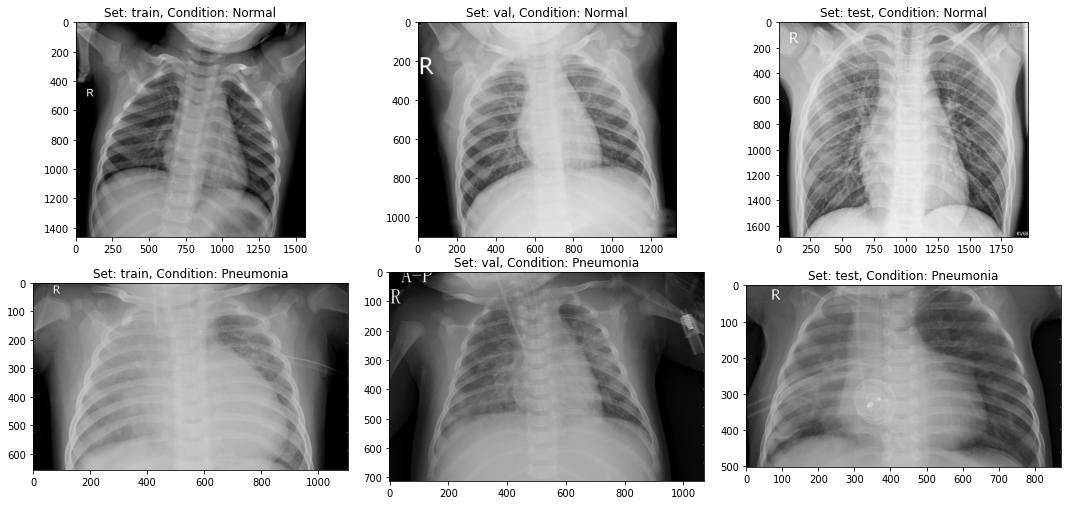

In [ ]:
input_path='/content/chest_xray/chest_xray/'
fig,ax=plt.subplots(2,3,figsize=(15,7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))


In [ ]:
for _set in ['train','val','test']:
  n_normal=len(os.listdir(input_path+_set+'/NORMAL'))
  n_infect=len(os.listdir(input_path+_set+'/PNEUMONIA'))
  print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, normal images: 1342, pneumonia images: 3876
Set: val, normal images: 9, pneumonia images: 9
Set: test, normal images: 234, pneumonia images: 390


## Data Augementation

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

In [ ]:

def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory=input_path+'train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
    directory=input_path+'test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)
    
    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [ ]:
img_dims=150
batch_size=32
epochs=10

In [ ]:
train_gen,test_gen,test_data,test_labels=process_data(img_dims,batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Model Building 

In [ ]:
from keras.models import Sequential,Model
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [ ]:
model=Sequential()

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu',input_shape=(img_dims,img_dims,3)))
model.add(MaxPool2D((2,2),strides=2,padding='same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2),strides=2,padding='same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2),strides=2,padding='same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2),strides=2,padding='same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2),strides=2,padding='same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dense(units = 1 , activation = 'sigmoid'))

In [ ]:
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 38, 38, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 19, 19, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 19, 19, 128)       7

In [ ]:
#CallBacks

checkpoint=ModelCheckpoint(filepath='best_weights.hdf5',save_best_only=True,save_weights_only=True)
lr_reduce=ReduceLROnPlateau(monitor='val_loss',factor=0.3,patience=2,verbose=2,mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [ ]:
hist=model.fit_generator(train_gen,steps_per_epoch=train_gen.samples//batch_size,epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

In [ ]:
model1 = Sequential()
model1.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape=(img_dims,img_dims,3)))
model1.add(BatchNormalization())
model1.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model1.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model1.add(Dropout(0.1))
model1.add(BatchNormalization())
model1.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model1.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model1.add(BatchNormalization())
model1.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model1.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model1.add(Dropout(0.2))
model1.add(BatchNormalization())
model1.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model1.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model1.add(Dropout(0.2))
model1.add(BatchNormalization())
model1.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model1.add(Flatten())
model1.add(Dense(units = 128 , activation = 'relu'))
model1.add(Dropout(0.2))
model1.add(Dense(units = 1 , activation = 'sigmoid'))
model1.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model1.summary()

In [ ]:
hist1=model1.fit_generator(train_gen,steps_per_epoch=train_gen.samples//batch_size,epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist1.history['accuracy'][-1])*100, 2)))

In [ ]:
inputs = Input(shape=(img_dims, img_dims, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.5)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.5)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.5)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model2 = Model(inputs=inputs, outputs=output)
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [ ]:
hist2=model2.fit_generator(train_gen,steps_per_epoch=train_gen.samples//batch_size,epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[lr_reduce])

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model2.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist2.history['accuracy'][-1])*100, 2)))

#Transfer Learning

### VGG-16 From Scratch

In [ ]:
from keras.applications.vgg16 import VGG16

In [ ]:
Num_classes=2
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [ ]:
x = base_model.output
x = Flatten()(x)
x = Dense(1, activation='sigmoid')(x)

model3 = Model(inputs=base_model.input, outputs=x)

model3.summary()

In [ ]:
for layer in model3.layers[0:20]:
    layer.trainable = False

In [ ]:
model3.compile(loss="binary_crossentropy", optimizer='adam',metrics=["accuracy"])

In [ ]:
hist3=model3.fit_generator(train_gen,steps_per_epoch=train_gen.samples//batch_size,epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[lr_reduce])

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model3.predict(test_data)

acc3 = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc3))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist3.history['accuracy'][-1])*100, 2)))

In [ ]:
from keras.applications.vgg19 import VGG19

In [ ]:
Num_classes=2
base_model1 = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(1, activation='sigmoid')(x)

model4 = Model(inputs=base_model.input, outputs=x)

model4.summary()

In [ ]:
for layer in model4.layers[0:20]:
    layer.trainable = False

In [ ]:
model4.compile(loss="binary_crossentropy", optimizer='adam',metrics=["accuracy"])

In [ ]:
hist4=model4.fit_generator(train_gen,steps_per_epoch=train_gen.samples//batch_size,epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[lr_reduce])

In [ ]:
preds = model4.predict(test_data)

acc4 = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist4.history['accuracy'][-1])*100, 2)))

## RESNET

In [ ]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model

In [ ]:
restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(150,150,3))

In [ ]:
output=restnet.layers[-1].output

output = keras.layers.Flatten()(output)

restnet = Model(restnet.input,outputs=output)
for layer in restnet.layers[0:20]:
    layer.trainable = False
restnet.summary()

In [ ]:
model5 = Sequential()
model5.add(restnet)
model5.add(Dense(256, activation='relu', input_dim=(150,150,3)))
model5.add(Dense(128, activation='relu'))
model5.add(Dense(1, activation='sigmoid'))
model5.compile(loss='binary_crossentropy',optimizer='adam',
              metrics=['accuracy'])
model5.summary()

In [ ]:
hist5=model5.fit_generator(train_gen,steps_per_epoch=train_gen.samples//batch_size,epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[lr_reduce])

In [ ]:
preds = model5.predict(test_data)

acc5 = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist5.history['accuracy'][-1])*100, 2)))

In [ ]:
train_accuracy=[]

for his in [hist1,hist2,hist3,hist4,hist5]:

  X=his.history.get('accuracy')[-1] 
  train_accuracy.append(X)

In [ ]:
train_accuracy

In [ ]:
train_accuracy=[]

for his in [hist1,hist2,hist3,hist4,hist5]:

  X=his.history.get('accuracy')[-1] 
  train_accuracy.append(X)